In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import tensorflow as tf
import os

print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.3.1
Num GPUs Available:  1


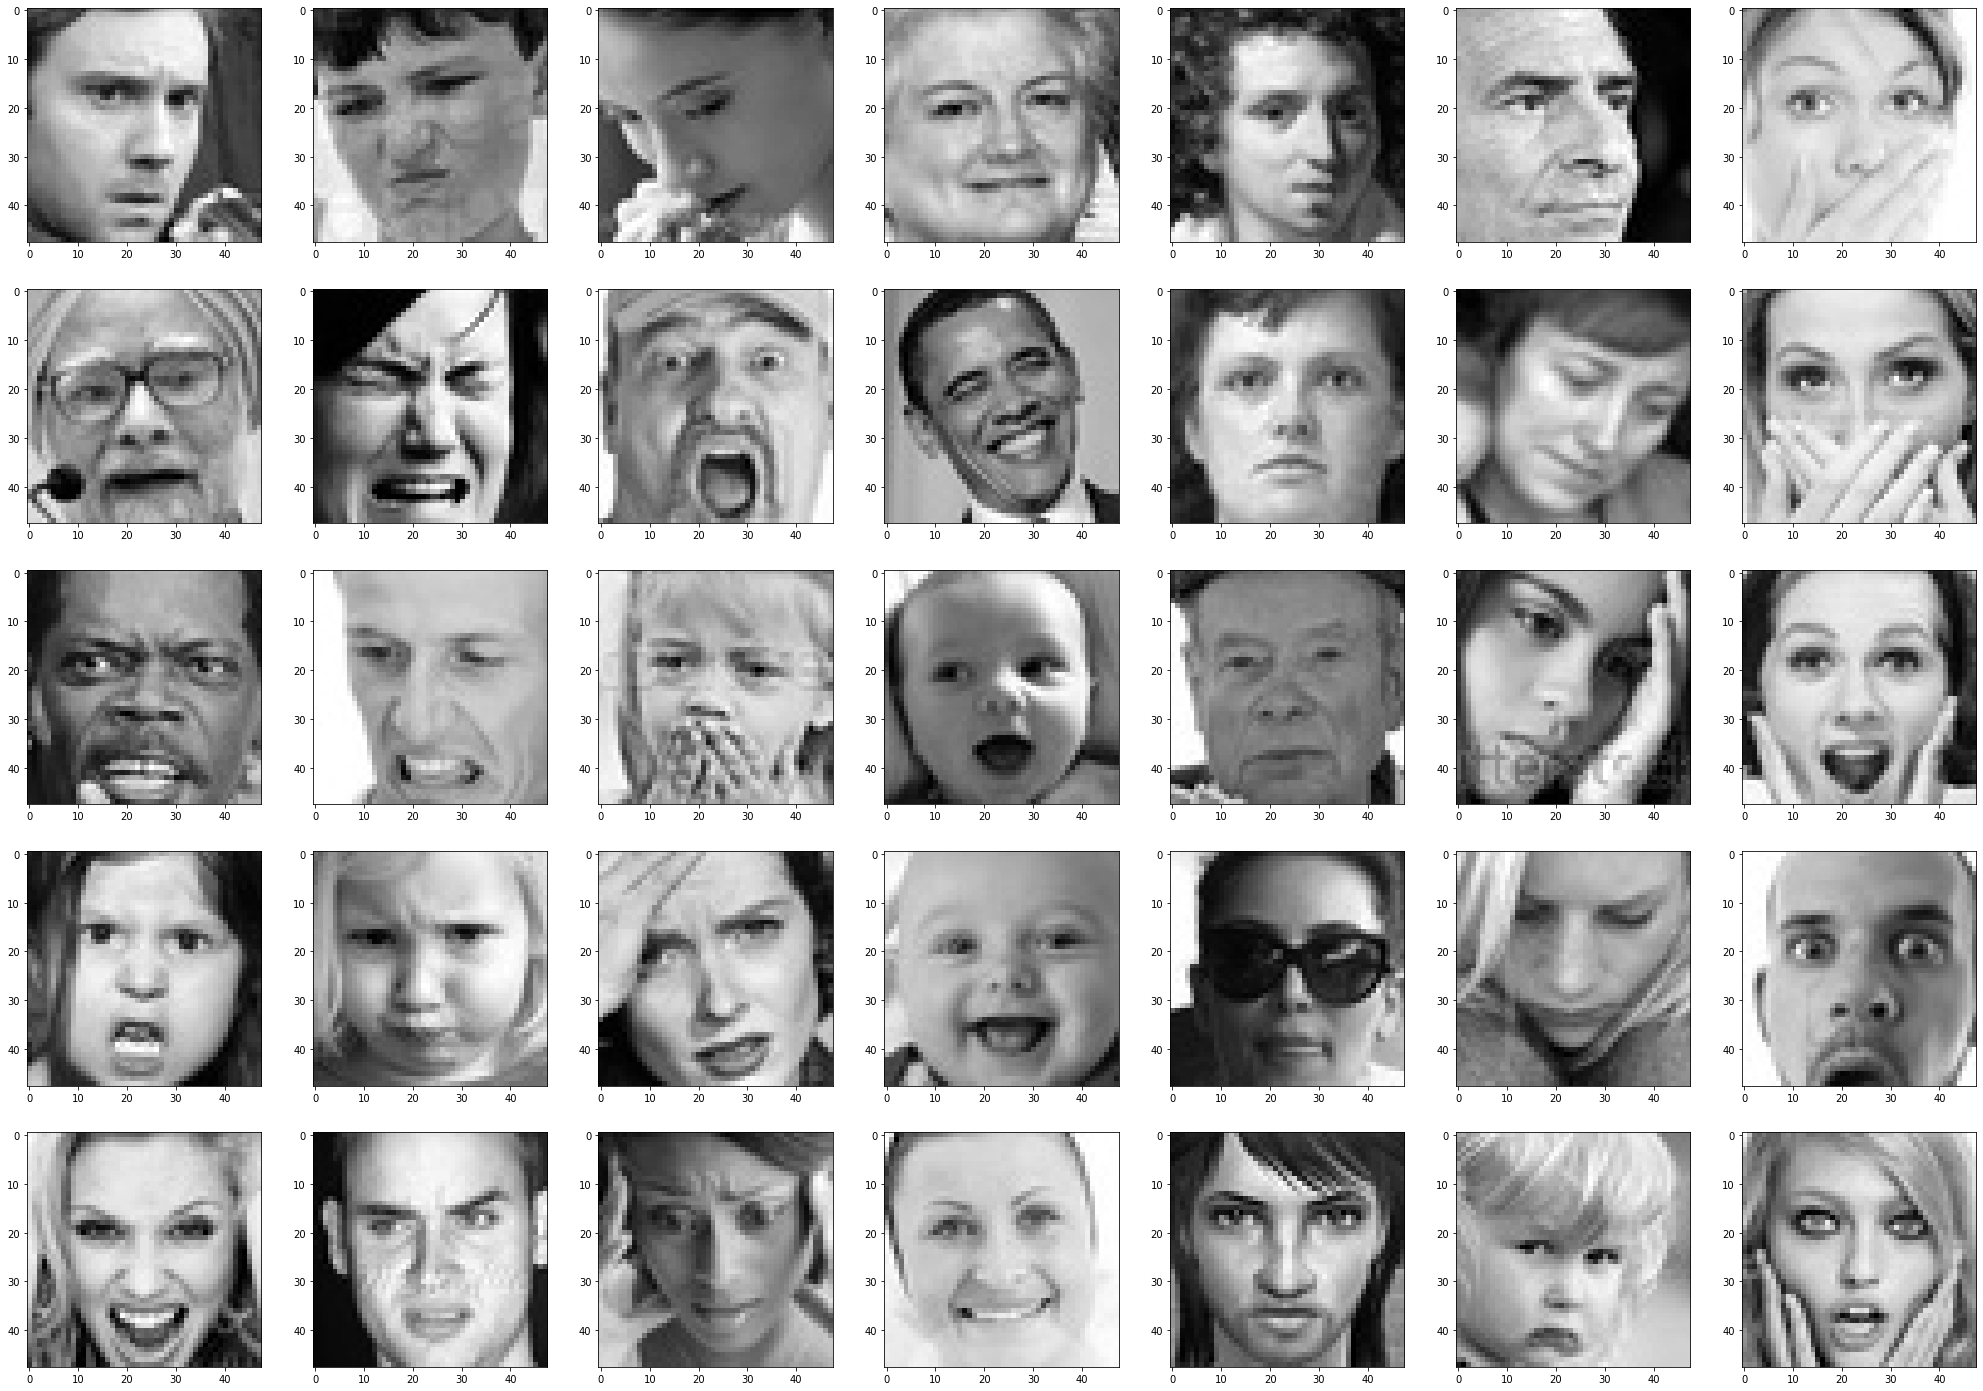

In [2]:
'''
https://www.kaggle.com/msambare/fer2013
https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset
'''
train_dir = "../../DATA/ExpressionData/train/"
test_dir = "../../DATA/ExpressionData/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

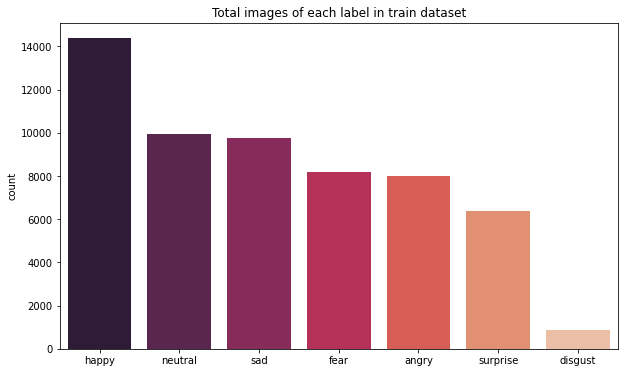

In [3]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="rocket", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

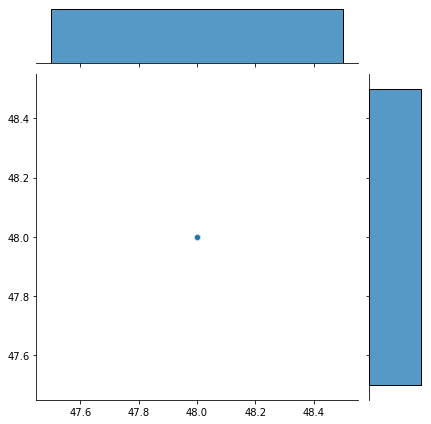

In [4]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2)
plt.show()

# Data Preprocessing

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 57530 images belonging to 7 classes.
Found 14244 images belonging to 7 classes.


# Create the Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.nn import relu, softmax
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import categorical_crossentropy

tf.keras.backend.clear_session()

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=relu, input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation=relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation=relu))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation=relu))
model.add(Dropout(0.2))

model.add(Dense(1024, activation=relu))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation=softmax))

model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss=categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

In [7]:
import pydot
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

early_stop = EarlyStopping(monitor='val_loss', patience=5)
# lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
callbacks = [early_stop,]

In [9]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 400

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/400
898/898 [==============================] - 39s 43ms/step - loss: 1.8411 - accuracy: 0.2386 - val_loss: 1.7900 - val_accuracy: 0.2691
Epoch 2/400
898/898 [==============================] - 37s 41ms/step - loss: 1.7804 - accuracy: 0.2635 - val_loss: 1.7106 - val_accuracy: 0.3058
Epoch 3/400
898/898 [==============================] - 37s 41ms/step - loss: 1.7422 - accuracy: 0.2852 - val_loss: 1.6647 - val_accuracy: 0.3362
Epoch 4/400
898/898 [==============================] - 37s 41ms/step - loss: 1.6832 - accuracy: 0.3203 - val_loss: 1.4766 - val_accuracy: 0.4213
Epoch 5/400
898/898 [==============================] - 37s 41ms/step - loss: 1.6093 - accuracy: 0.3610 - val_loss: 1.4228 - val_accuracy: 0.4460
Epoch 6/400
898/898 [==============================] - 37s 41ms/step - loss: 1.5347 - accuracy: 0.3989 - val_loss: 1.3783 - val_accuracy: 0.4561
Epoch 7/400
898/898 [==============================] - 37s 41ms/step - loss: 1.4778 - accuracy: 0.4243 - val_loss: 1.2780 - val_ac

# Evaluate The Model

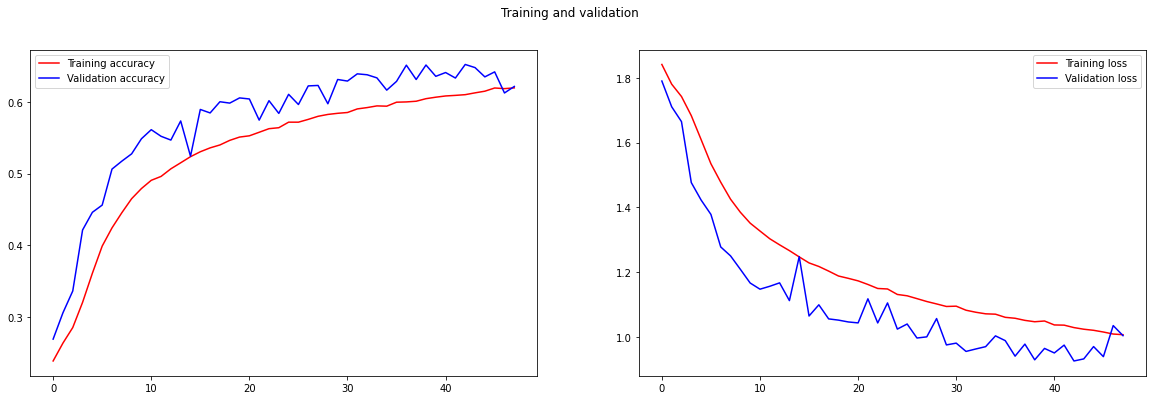

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'r', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

223/223 [==============================] - 4s 16ms/step - loss: 1.0034 - accuracy: 0.6222
validation accuracy : 62.215667963027954%
validation loss : 1.0034234523773193


              precision    recall  f1-score   support

       angry       0.63      0.47      0.54      1918
     disgust       0.80      0.27      0.40       222
        fear       0.59      0.24      0.34      2042
       happy       0.88      0.85      0.86      3599
     neutral       0.46      0.73      0.57      2449
         sad       0.45      0.58      0.51      2386
    surprise       0.80      0.72      0.76      1628

    accuracy                           0.62     14244
   macro avg       0.66      0.55      0.57     14244
weighted avg       0.65      0.62      0.62     14244





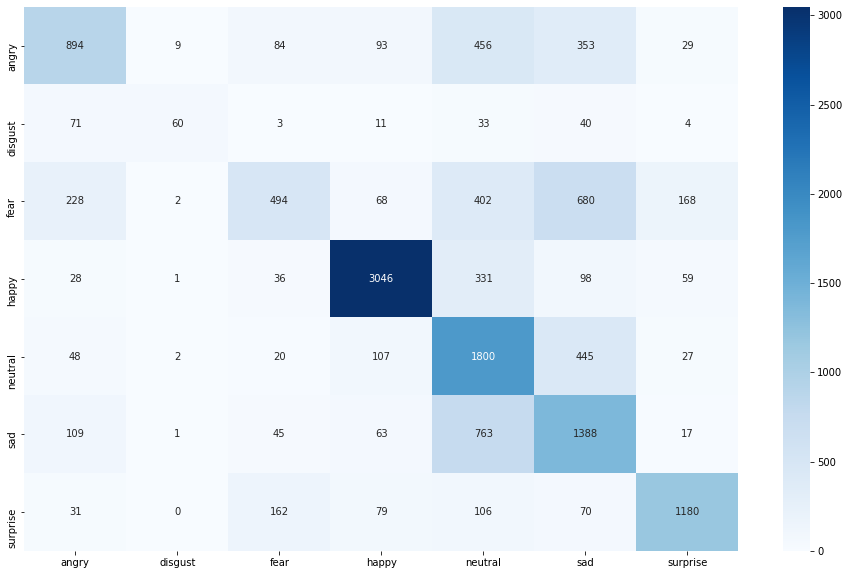

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()